**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 2 and 3: Assignment (200 points + 20 bonus points + 1 bonus point for each bug you find and another bonus point if you debug it and before you ask, no, typos unfortunately are not considered bugs - first come, first served)*  
Author: Umut

In [88]:
# Group number: 24
# Franka Buytenhuijs, s4356845
# Hugo Chateau-Laurent, s1023970
# Maria Tsfasman, s1021505

In [89]:
batch_size = 2
data_directory = './resized_data/'  # Make a directory to store the data and enter it here.
                    # We will be using a smaller dataset (LFW) than the one used in the paper (CelebA) for computational resource considerations.
                    # Download it from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz.
device = 0
epochs = 45
lambda_ = {'feature': 1., 'pixel': 1., 'total_variation': 1e-5}
model_directory = './models' # Make a directory to store the models and enter it here. Move Vgg4Layers.npz to the model directory.
outsize = (96, 96)

**Packages (10 points)**  
In this cell, you will import the required packages.  
*Tasks*   
- (1) It is always good practice to first think about the big picture and not rush into writing code before clearly knowing everything that you will have to do so as to avoid future complications. Therefore, your first task is to study the skeleton code and come up with a plan of how to proceed. (**0 points**)
- (2) However, I agree that doing so is arguably the most boring part of coding, and you rather skip it. To help you to resist the temptation of skipping going through the skeleton code, I have removed the import statements. Your second task is to Identify the required packages and import them. Note that if you are using Python 2.7, you should import print from the future. (**10 points**)

In [90]:
# (2) start
import chainer
from chainer import Chain, ChainList
from chainer.optimizers import Adam
from chainer import iterators
from chainer.backends import cuda
import chainer.functions as F
import chainer.links as L
import numpy as np
import cv2
import os
import glob
from glob import glob
from chainer.serializers import load_npz, save_npz
from PIL import Image
from pprint import pprint
from chainer.dataset import concat_examples
from matplotlib import pyplot as plt
from chainer.dataset import DatasetMixin
# (2) end

**Preprocessing functions (10 points + 5 bonus points)** (taken from https://github.com/mbeyeler/opencv-python-blueprints)  
In the following cell, you will implement some of the preprocessing functions. The rest of the preprocessing steps have already been applied to the data.  
*Tasks*
- (1) Implement the resizing operation. That is, you should extract the data, resize each portrait to 96 pixels x 96 pixels and save them to the data directory as JPG. (**10 points **)
- (2) The pencil sketch class implements the sketch effect in a simpler way than the one mentioned in the lecture. Explain how/why the used operations (blur and divide) convert portraits to sketches, and how it differs from that which was mentioned in the lecture? (**5 bonus points**)

In [91]:
# (1) start

def resize_images():
    data = []
    files = glob.glob('./data/*/*.jpg')
    
    for index, file in enumerate(files):
        new = file.replace('\\', '/')
        read_img = cv2.imread(new)
        resized_image = cv2.resize(read_img, outsize) 
        cv2.imwrite((data_directory + str(index) + '.jpg'), resized_image)
# resize_images()
# (1) end
    

In [92]:



    
class PencilSketch:
    """Pencil sketch effect
        A class that applies a pencil sketch effect to an image.
    """

    def __init__(self, dimension, bg_gray='pencilsketch_bg.jpg'):
        """Initialize paramete
            :param dimensions: Image size (width and height).
        """
        self.width, self.height = dimension

    def render(self, img_rgb):
        """Applies pencil sketch effect to an RGB image
            :param img_rgb: RGB image to be processed
            :returns: Processed RGB image
        """
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0, 0)
        img_blend = cv2.divide(img_gray, img_blur, scale=256)

        # return cv2.cvtColor(img_blend, cv2.COLOR_GRAY2RGB)
        return img_blend

def pencil_sketch(img_rgb):
    pencilSketch = PencilSketch((img_rgb.shape[1], img_rgb.shape[0]))

    return pencilSketch.render(img_rgb)

# (2) The pencilsketch class uses three methods to get the sketcheffect. First it make the picture black/white instead of coloured 
# Secondly, it uses a Gaussian kernel to reduce the details in the picture and blur the edges and lastly, it divides the 
# first and second array to get the difference of these pictures in order to get the real greyscale sketch effect.
# compared to the lecture, we don't use advanced edge detection, like the method by Gastal and Oliveira, but use a simple relative
# simple method: the Gaussian Kernel here.

def preprocess(img):
    if img.mode == 'L':
        return np.rollaxis(np.asarray(img, 'float32')[..., None], 2)
    else:
        return np.rollaxis(np.asarray(img, 'float32')[..., ::-1], 2)
    
    
# start
sketch_test = False # if you want to compute the sketched imgs

if(sketch_test):
    files = glob('./resized_data/*.jpg')
    data_directory = './sketched_data/'  # Make a directory to store the data and enter it here.

    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    for index, file in enumerate(files):
        new = file.replace('\\', '/')
        read_img = cv2.imread(new)
        sketched = pencil_sketch(read_img)
        cv2.imwrite((data_directory + str(index) + '.jpg'), sketched)
# end   


**Data class**  
The following cell defines the data class. It is used to manage the data (loading, etc.). *You do not have to make any changes to the code.*  
*Task*
- (1) Study the code and refer to the chainer documentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)

In [93]:
class Dataset(DatasetMixin):
    def __init__(self, data_files):
        self.data_files = data_files

    def __len__(self):
        return len(self.data_files)

    def get_example(self, i):
        t = np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f').transpose(2, 0, 1)
        x = pencil_sketch(np.asarray((Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS)), 'f'))[None]
        return t, x

**Model classes (45 points)**  
In the following cellyou will implement the model classes.
*Tasks*   
- (1) Implement the layers of the model by filling in the missing code. (**20 points**)
- (2) Reimplement the model as a ChainList instead of a Chain. (**5 points**)
- (3) Implement the forward pass of the residual block by filling in the missing code. (**20 points**)

In [94]:
'''
class Model(Chain):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()

        with self.init_scope():
            
            # (1) start
            self.convolution2D_0 = L.Convolution2D(in_channels = in_channels, out_channels = 32, ksize = 9, stride = 1, pad = 4, nobias = True)
            self.batchNormalization_0 = L.BatchNormalization(32)
            self.convolution2D_1 = L.Convolution2D(in_channels = 32, out_channels = 64, ksize = 3, stride = 2, pad = 1, nobias = True)
            self.batchNormalization_1 = L.BatchNormalization(64)
            self.convolution2D_2 = L.Convolution2D(in_channels = 64, out_channels = 128, ksize = 3, stride = 2, pad = 1, nobias = True)
            self.batchNormalization_2 = L.BatchNormalization(128)
            self.residualBlock_3 =  ResidualBlock(128, 128)
            self.residualBlock_4 = ResidualBlock(128, 128) 
            self.residualBlock_5 = ResidualBlock(128, 128) 
            self.residualBlock_6 = ResidualBlock(128, 128) 
            self.residualBlock_7 = ResidualBlock(128, 128) 
            self.deconvolution2D_8 = L.Deconvolution2D(in_channels = 128, out_channels = 64, ksize = 3, stride = 2, pad = 1, nobias = True, outsize = (48,48))
            self.batchNormalization_8 = L.BatchNormalization(64)
            # (1) end
            
            self.deconvolution2D_9 = L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize)
            self.batchNormalization_9 = L.BatchNormalization(32)
            self.convolution2D_10 = L.Convolution2D(32, 3, 9, pad = 4, nobias = True)
            self.batchNormalization_10 = L.BatchNormalization(3)

        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_2(h)
        h = self.batchNormalization_2(h, finetune)
        h = F.relu(h)
        h = self.residualBlock_3(h, finetune)
        h = self.residualBlock_4(h, finetune)
        h = self.residualBlock_5(h, finetune)
        h = self.residualBlock_6(h, finetune)
        h = self.residualBlock_7(h, finetune)
        h = self.deconvolution2D_8(h)
        h = self.batchNormalization_8(h, finetune)
        h = F.relu(h)
        h = self.deconvolution2D_9(h)
        h = self.batchNormalization_9(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_10(h)
        h = self.batchNormalization_10(h, finetune)
        y = 127.5 * F.tanh(h) + 127.5

        return y
'''

# (2) start
class Model(ChainList):
    
    def __init__(self, in_channels, outsize):        
        super(Model, self).__init__()
        self.in_channels = in_channels
        self.outsize = outsize
        
        with self.init_scope():
            self.append(Convolution2DBlock(in_channels, 32, 9, 1, 4, True))
            self.append(Convolution2DBlock(32, 64, 3, 2, 1, True))
            self.append(Convolution2DBlock(64, 128, 3, 2, 1, True))
            self.append(ResidualBlock(128, 128))
            self.append(ResidualBlock(128, 128))
            self.append(ResidualBlock(128, 128))
            self.append(ResidualBlock(128, 128))
            self.append(ResidualBlock(128, 128))
            self.append(Convolution2DBlock(128, 64, 3, 2, 1, True, deconv=True, outsize = (48,48)))
            self.append(Convolution2DBlock(64, 32, 3, 2, 1, True, deconv=True, outsize=outsize))
            self.append(Convolution2DBlock(32, 3, 9, 1, 4, True, relu=False))

            
            
    def __call__(self, x, finetune = False):
        h = x
        for i in range(self.__len__()):
            h = self.__getitem__(i)(h, finetune=finetune)
        y = 127.5 * F.tanh(h) + 127.5
        
        return y
    
class Convolution2DBlock(ChainList):
    def __init__(self, in_channels, out_channels, ksize, stride, pad, nobias = False, deconv=False, relu=True, outsize=None):
        super(Convolution2DBlock, self).__init__()

        with self.init_scope():
            if deconv:
                self.append(L.Deconvolution2D(in_channels, out_channels, ksize, stride, pad, nobias, outsize=outsize))
            else:
                self.append(L.Convolution2D(in_channels, out_channels, ksize, stride, pad, nobias))

            self.append(L.BatchNormalization(out_channels))
        
        self.relu=relu
        
    def __call__(self, x, finetune = False):
        h = x
        for i in range(self.__len__()):
            try:
                h = self.__getitem__(i)(h, finetune=finetune)
            except TypeError:
                h = self.__getitem__(i)(h)
        if self.relu:
            h = F.relu(h)
        return h
# (2) end


    
class ResidualBlock(Chain):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        with self.init_scope():
            self.batchNormalization_0 = L.BatchNormalization(out_channels)
            self.batchNormalization_1 = L.BatchNormalization(out_channels)
            self.convolution2D_0 = L.Convolution2D(in_channels, out_channels, 3, pad = 1, nobias = True)
            self.convolution2D_1 = L.Convolution2D(out_channels, out_channels, 3, pad = 1, nobias = True)

        self.in_channels = in_channels
        self.out_channels = out_channels

    def __call__(self, x, finetune = False):
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune=finetune)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune=finetune)
        h = F.relu(h)
        y = h + x

        return y

**Loss classes (45 points)**  
In the following cell, you will implement the loss classes.  
*Tasks*  
- (1) You are provided with a custom VGG-16 implementation. How does it differ than the original implementation? Why can we get away with using the simpler implementation? (**5 points**)
- (2) Implement the missing convolution layer of the total variation loss by filling in the missing code. (**10 points**)
- (3) Implement the forward pass of the total variation loss by filling in the missing code. (**10 points**)
- (4) Implement the feature loss component in the forward pass of the loss function by filling in the missing code. (**10 points**)
- (5) Explain why the loss components are scaled. (**5 points**)
- (6) Explain why the target features are extracted in test mode. (**5 points**)

In [95]:
class Vgg4Layers(Chain):
    
    def __init__(self):
        super(Vgg4Layers, self).__init__()

        with self.init_scope():
            self.conv1_1 = L.Convolution2D( 3, 64, 3, pad = 1)
            self.conv1_2 = L.Convolution2D( 64, 64, 3, pad = 1)
            self.conv2_1 = L.Convolution2D( 64, 128, 3, pad = 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, pad = 1)

        

    def __call__(self, x):
        h = x - F.broadcast_to(self.mean, x.shape)
        h = self.conv1_1(h)
        h = F.relu(h)
        h = self.conv1_2(h)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 2, 2)
        h = self.conv2_1(h)
        h = F.relu(h)
        h = self.conv2_2(h)
        y = F.relu(h)

        return y

class TotalVariationLoss(Chain):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

        with self.init_scope():
            self.convolution2D_0 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[-1], [1]]]], 'float32'))
            # (2) start
            self.convolution2D_1 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[-1, 1]]]], 'float32'))
            # (2) end

    def __call__(self, x):
        h = self.convolution2D_0(x)
        h = np.square(h)

        h1 = self.convolution2D_1(x)
        h1 = np.square(h1)

        sumh1h = np.sum((h1,h))
        y = (sumh1h ** 0.5)
        
        return y

class LossFunction(object):
    def __init__(self, lambda_):
        self.totalVariationLoss = TotalVariationLoss()
        self.vgg4Layers         = Vgg4Layers()

    def __call__(self, t, y):            
        with chainer.using_config('train', False):
            t_ = self.vgg4Layers(t)

        # (4) start
        y_ = self.vgg4Layers(y)
        feature_loss = F.mean_squared_error(t_, y_)
        # (4) end
        
        pixel_loss = lambda_['pixel'] * F.mean_squared_error(t , y) 
        total_variation_loss = lambda_['total_variation'] * self.totalVariationLoss(y)
        loss = feature_loss + pixel_loss + total_variation_loss
        return loss

# (1) The VGG-4 has only 4 layers instead of the 16 layers in the origional VGG-16. 
# Why can we get away with using simpler implementation? It might work ok on 4 layers,
# more layers wouldn’t make it worse for the performance.
# But if it has something to learn, than it'll improve a lot
# However, the more layers, the more memory it takes, so for us 4 is enough:)
# (5) Explain why the loss components are scaled: 
# We want them to be on the same scale for them to be comparable and overall to reflect real state of loss.
# (6) Because it's a pretrained network (we don't have to retrain it).

**Initialization (10 points)**  
The following cell initializes the loss function, the loss history, the model, the optimizer, the datasets and the iterators. *You do not have to make any changes to the code.*  
*Tasks*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)  
- (2) What are the boolean arguments that are passed to the SerialIterator class? (**5 points**)  
- (3) Why is it false for the training iterator but not for other iterators? In other words, what would happen if we were to set it to false for the training iterator and true for the other iterators? (**5 points**)

In [96]:
lossFunction = LossFunction(lambda_)
load_npz('{:s}/Vgg4Layers.npz'.format(model_directory), lossFunction.vgg4Layers)
lossFunction.vgg4Layers.add_persistent('mean', np.array([[[[103.939]], [[116.779]], [[123.68]]]], 'float32'))
loss_history = {'training': [], 'validation': []}

model = Model(1, outsize) if device < 0 else Model(1, outsize).to_gpu(device)
if device >= 0:
    lossFunction.vgg4Layers.to_gpu(device)
    lossFunction.totalVariationLoss.to_gpu(device)


optimizer = Adam()

optimizer.setup(model)

data_file = sorted(glob('{}/*.jpg'.format(data_directory)))
validation_proportion = .0025
#validation_proportion = .8
training_proportion = .002
#training_proportion = .64

training_set = Dataset(data_file[:int(training_proportion * len(data_file))])
validation_set = Dataset(data_file[int(training_proportion * len(data_file)) : int(validation_proportion * len(data_file))])
print(training_set.__len__())
print(validation_set.__len__())

#pprint(vars(validation_set))

test_set = Dataset(data_file[int(validation_proportion * len(data_file)) :])
training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
validation_iterator = iterators.SerialIterator(validation_set, batch_size, False, False)
test_iterator = iterators.SerialIterator(test_set , batch_size, False, False)

# (2) repeat defines whether or not the iterator starts again after iterating over all the examples. 
#     shuffle is used to iterate over the examples in a random order.
# (3) During the testing and validation process, you want to be able to reproduce the results. Therefore shuffle
#     should be set to False. During the training process, it is better to shuffle the examples so that the model
#     does not overfit according to patterns in the examples' sequence.

26
7


**Training and validation (20 points)**  
In the following cell, you will train and validate your model.
*Tasks*   
- (1) Implement training loss estimation, backprop and parameter update. (**10 points**)
- (2) Implement validation loss history (**5 points**)
- (3) Implement model serialization  (**5 points**)

In [97]:
for i in range(epochs):
    training_iterator.reset()
    validation_iterator.reset()
    
    print('Starting epoch '+str(i))
    loss_history['training'].append(0)
    for j, batch in enumerate(training_iterator):
        with chainer.using_config('train', True):
            t, x = concat_examples(batch, device)
            y = model(x)
            
            # (1) start
            print("before lossfunction")
            loss = lossFunction(t, y)
            print("after lossfunction")
            model.cleargrads()
            loss.backward()

            optimizer.update()
            # (1) end
        
        loss_history['training'][-1] += float(loss.data)

    loss_history['training'][-1] /= j + 1
    # (2) start
    loss_history['validation'].append(0)

    for j, batch in enumerate(validation_iterator):
        with chainer.using_config('train', False):
            t, x = concat_examples(batch, device)
            y = model(x)
            loss = lossFunction(t, y)
        loss_history['validation'][-1] += float(loss.data)

    loss_history['validation'][-1] /= j + 1
    
    
    
    # (2) end
    #print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}.'.format(i + 1, epochs, loss_history['training'], loss_history['validation']))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, i), loss_history)
    # (3) start
    save_npz('{:s}/weights_{:03d}.model'.format(model_directory,i), model)
    # (3) end
    save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, i), optimizer)

Starting epoch 0
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction
before lossfunction
after lossfunction


FileNotFoundError: [Errno 2] No such file or directory: './resized_data/10014.jpg'

**Test (45 points + 15 bonus points)**  
In the following cell, you will test your model.  
*Tasks*
- (1) Estimate the test loss, print it and save it. (**15 points**)
- (2) Estimate the validation metrics, print them and save them (tip: scikit-image) (**15 bonus points**)
- (3) Plot example results (i.e., plot a few t, x and y) (**10 points**)
- (4) Dicuss your implementation in 300 - 350 words (e.g., how good your results are, how you can improve your model, etc.) (**20 points**)

In [ ]:
# (1), (2) and (3) start
for j, batch in enumerate(test_iterator):
    with chainer.using_config('train', False):
        t, x = concat_examples(batch, device)
        t = np.array(t)
        y = model(x)
        
        original = t[0].transpose(1,2,0)/255
        sketch = x[0][0]
        plt.figure()
        plt.imshow(original)
        plt.figure()
        plt.imshow(sketch, cmap='gray')
        
        output=y[0].transpose(1,2,0)
        print(output)
        plt.imshow(output)
        loss = lossFunction(t, y)
# (1), (2) and (3) end

# (4) Write your answer here.

In [74]:

epochs = 50

loss_hist = np.load('models/loss_history_'+'{:03d}'.format(epochs)+'.npz')
for varName in loss_hist:
    loss_histories=loss_hist[varName]

exec('results='+str(loss_histories))

print len(results['validation']), len([x for x in results['validation'] if x==0])
for key in results:
    results[key] = [x for x in results[key] if x!=0]
    # print key
    plt.plot(range(len(results[key])), results[key], label=key)

plt.legend()
plt.show()


SyntaxError: invalid syntax (<ipython-input-74-3a9958de7bef>, line 10)

TypeError: incompatible array types are mixed in the forward input (Convolution2DFunction).
Actual: <class 'numpy.ndarray'>, <class 'cupy.core.core.ndarray'>

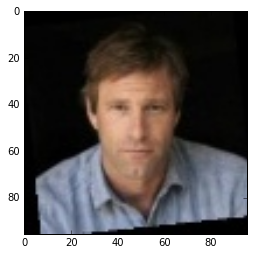

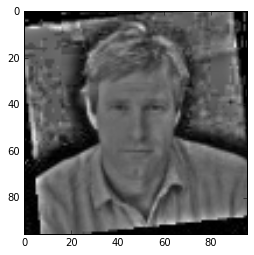

In [75]:
a=training_set.get_example(0)

original = a[0].transpose(1,2,0)/255
sketch = a[1][0]


plt.figure()
plt.imshow(original)
plt.figure()
plt.imshow(sketch, cmap="gray")

prediction = model(training_set.get_example(0)[1])
